# Exercise 1: Backtesting with a single time series

In this notebook we set out an exercise to do backtesting to compare different models for a single time series. The solutions we show are only one way of answering these questions.

Note: Since recording the videos, skforecast have made breaking changes to their API in newer versions (>= 0.14). This notebook has been updated for use with skforecast version 0.14 and above, which are the versions with a new API. If you are using older versions of skforecast (<0.14) see the migration guide here: https://skforecast.org/0.14.0/user_guides/migration-guide.html

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Data preparation

The dataset we shall use is the daily web visits to cienciadedatos.net.

In [2]:
from skforecast.datasets import fetch_dataset

# Load the data
data = fetch_dataset(name="website_visits", raw=True)
data.head()

website_visits
--------------
Daily visits to the cienciadedatos.net website registered with the google
analytics service.
Amat Rodrigo, J. (2021). cienciadedatos.net (1.0.0). Zenodo.
https://doi.org/10.5281/zenodo.10006330
Shape of the dataset: (421, 2)


,date,users
0,1/7/20,2324
1,2/7/20,2201
2,3/7/20,2146
3,4/7/20,1666
4,5/7/20,1433


Pre-process the data by performing the following:
1) Convert the `date` column to datetime type
2) Set the date as an index
3) Set the frequency to daily
4) Sort the time series by date

Hint: Try the format `%d/%m/%y`

In [3]:
data["date"] = pd.to_datetime(data["date"], format="%d/%m/%y")
data = data.set_index("date")
data = data.asfreq("D")
data = data.sort_index()

Check for missing values.

In [4]:
data.isnull().any()

users    False
dtype: bool

# Exploratory data analysis

Print the number of data points in the time series, the start time, and the end time of the time series.

In [5]:
print(len(data))
print(f"start: {data.index.min()}, end: {data.index.max()}")

421
start: 2020-07-01 00:00:00, end: 2021-08-25 00:00:00


Plot the time series

Text(0.5, 1.0, 'Number of daily visits')

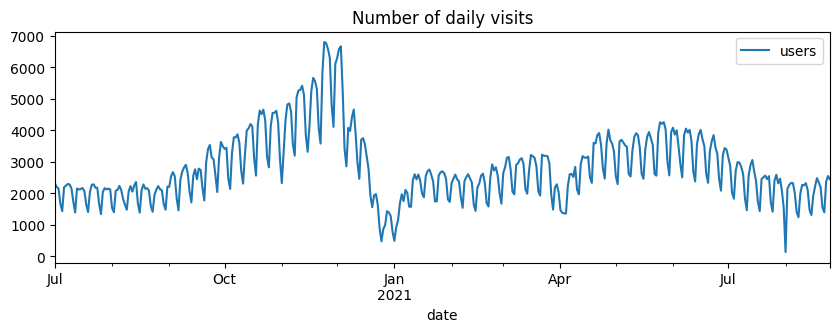

In [6]:
fig, ax = plt.subplots(figsize=[10, 3])
data.plot(ax=ax)
ax.set_title("Number of daily visits")

Check if there is any weekly seasonality. 

Note: This could be done in a variety ways with different degrees of complexity. 

<Axes: xlabel='day_of_week'>

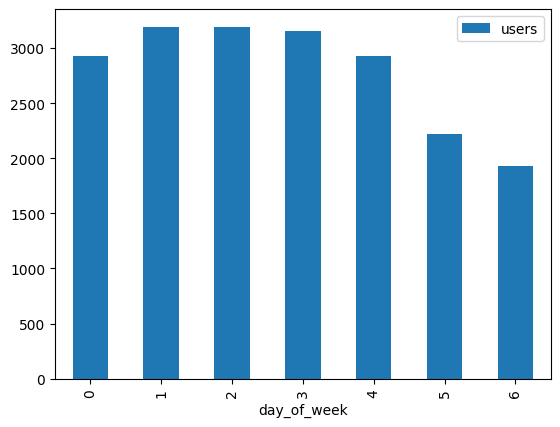

In [7]:
# Plot the mean value of visits grouped by weekday. This is a very
# quick and dirty way to check for seasonality. It is not
# ideal if there is a lot of trend in the data. But it can help
# build a quick intuition.

(
    data.assign(day_of_week=lambda df: df.index.weekday)  # Add day of week column
    .groupby("day_of_week")  # Groupby day of week and take the mean
    .mean()
).plot(kind="bar")

There appears to be weekly seasonality. There is less traffic to the website on weekends. Including a feature to capture weekly seasonality would therefore be useful.

Create a feature(s) which can help capture weekly seasonality from the datetime index.

In [8]:
from sklearn.pipeline import Pipeline
from feature_engine.creation import CyclicalFeatures # Using feature-engine package here
from sktime.transformations.series.date import DateTimeFeatures # Using sktime package here

datetime_trafo = DateTimeFeatures(manual_selection=["day_of_week"], 
                                  keep_original_columns=True) # Needed to keep `users` column
cyclical_trafo = CyclicalFeatures(variables=["day_of_week"], 
                                  drop_original=False) # Needed to keep `users` column

# Let's create a pipeline to make our exogenous features
feature_eng_pipeline = Pipeline(steps=[("datetime_features", datetime_trafo), 
                                      ("cyclical_features", cyclical_trafo),]
                               )

data = feature_eng_pipeline.fit_transform(data)
data.head()

/Users/kishanmanani/.pyenv/versions/3.12.3/envs/general/lib/python3.12/site-packages/sktime/transformations/series/date.py:448: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  DUMMIES = DUMMIES.replace(
/Users/kishanmanani/.pyenv/versions/3.12.3/envs/general/lib/python3.12/site-packages/sktime/transformations/series/date.py:448: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  DUMMIES = DUMMIES.replace(


,users,day_of_week,day_of_week_sin,day_of_week_cos
date,,,,
2020-07-01,2324,2,8.660254e-01,-0.5
2020-07-02,2201,3,1.224647e-16,-1.0
2020-07-03,2146,4,-8.660254e-01,-0.5
2020-07-04,1666,5,-8.660254e-01,0.5
2020-07-05,1433,6,-2.449294e-16,1.0


# Model definition

Import the class needed for recursive forecasting with a single time series from `skforecast`.

In [9]:
# Single time series forecasters (recursive)
from skforecast.recursive import ForecasterRecursive

Import a transformer from sklearn to scale the data.

In [10]:
# Preprocessing and features
from sklearn.preprocessing import StandardScaler

Import a linear model and LightGBM

In [11]:
# Traditional machine learning models
from sklearn.linear_model import Ridge
from lightgbm import LGBMRegressor

Define one forecaster for the linear model and one forecaster for the LightGBM model  using `skforecast`. Use some recent lags and a lag of 7 to capture weekly seasonality.

In [12]:
# Define the lags to use
lags = 7  # Use all the lags up to 7 as features

# Create linear forecaster
linear_forecaster = ForecasterRecursive(
    regressor=Ridge(alpha=1),
    lags=lags,
    transformer_y=StandardScaler(),  # Scaling helpful for
    transformer_exog=StandardScaler(),  # linear models.
)

# Create LightGBM forecaster
params_lgbm = {
    "n_estimators": 100,
    "learning_rate": 0.1,
    "max_depth": 10,
    "random_state": 123,
    "verbose": -1,
}

lightgbm_forecaster = ForecasterRecursive(
    regressor=LGBMRegressor(**params_lgbm),
    lags=lags,
)

# Backtesting

Import the relevant backtesting objects from `skforecast`.

In [13]:
from skforecast.model_selection import backtesting_forecaster, TimeSeriesFold

Use `backtesting_forecaster` to do backtesting with:
- Intermittent refitting where the model is refit every 7 steps
- An expanding training window
- Using both the `mean_squared_error` and the `mean_absolute_percentage_error`
- Use approximately the first 30 days for training
- Use exogenous features

Do this twice, once for the linear forecaster and once for the lightgbm forecaster.

In [14]:
# Define how time series will be split during backtesting
cv = TimeSeriesFold(
    steps=7,
    initial_train_size=30,
    refit=7,
    allow_incomplete_fold=True,
    fixed_train_size=False,
)

In [15]:
# Linear forecaster backtesting
metric_linear, predictions_linear = backtesting_forecaster(
    forecaster=linear_forecaster,
    y=data["users"],
    exog=data[["day_of_week", "day_of_week_sin", "day_of_week_cos"]],
    cv=cv,
    metric=["mean_squared_error", "mean_absolute_percentage_error"],
    verbose=True,
    show_progress=True,
)

Information of folds
--------------------
Number of observations used for initial training: 30
Number of observations used for backtesting: 391
    Number of folds: 56
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude between last observed data (last window) and predictions (gap): 0
    Last fold only includes 6 observations.

Fold: 0
    Training:   2020-07-01 00:00:00 -- 2020-07-30 00:00:00  (n=30)
    Validation: 2020-07-31 00:00:00 -- 2020-08-06 00:00:00  (n=7)
Fold: 1
    Training:   No training in this fold
    Validation: 2020-08-07 00:00:00 -- 2020-08-13 00:00:00  (n=7)
Fold: 2
    Training:   No training in this fold
    Validation: 2020-08-14 00:00:00 -- 2020-08-20 00:00:00  (n=7)
Fold: 3
    Training:   No training in this fold
    Validation: 2020-08-21 00:00:00 -- 2020-08-27 00:00:00  (n=7)
Fold: 4
    Training:   No training in this fold
    Validation: 2020-08-28 00:00:00 -- 2020-09-03 00:00:00  (n=7)
Fold: 5
    Training:   No t

  0%|          | 0/56 [00:00<?, ?it/s]

In [16]:
# LightGBM backtesting
metric_lightgbm, predictions_lightgbm = backtesting_forecaster(
    forecaster=lightgbm_forecaster,
    y=data["users"],
    exog=data[["day_of_week", "day_of_week_sin", "day_of_week_cos"]],
    cv=cv,
    metric=["mean_squared_error", "mean_absolute_percentage_error"],
    verbose=True,
    show_progress=True,
)

Information of folds
--------------------
Number of observations used for initial training: 30
Number of observations used for backtesting: 391
    Number of folds: 56
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude between last observed data (last window) and predictions (gap): 0
    Last fold only includes 6 observations.

Fold: 0
    Training:   2020-07-01 00:00:00 -- 2020-07-30 00:00:00  (n=30)
    Validation: 2020-07-31 00:00:00 -- 2020-08-06 00:00:00  (n=7)
Fold: 1
    Training:   No training in this fold
    Validation: 2020-08-07 00:00:00 -- 2020-08-13 00:00:00  (n=7)
Fold: 2
    Training:   No training in this fold
    Validation: 2020-08-14 00:00:00 -- 2020-08-20 00:00:00  (n=7)
Fold: 3
    Training:   No training in this fold
    Validation: 2020-08-21 00:00:00 -- 2020-08-27 00:00:00  (n=7)
Fold: 4
    Training:   No training in this fold
    Validation: 2020-08-28 00:00:00 -- 2020-09-03 00:00:00  (n=7)
Fold: 5
    Training:   No t

  0%|          | 0/56 [00:00<?, ?it/s]

Compare the metrics for the linear model and lightgbm model. Which model did better?

In [17]:
print(f"MSE:{metric_linear["mean_squared_error"].values[0]}, MAPE:{metric_linear["mean_absolute_percentage_error"].values[0]}")
print(f"MSE:{metric_lightgbm["mean_squared_error"].values[0]}, MAPE:{metric_lightgbm["mean_absolute_percentage_error"].values[0]}")


MSE:271790.98001432215, MAPE:0.1521400490226939
MSE:561320.5556458909, MAPE:0.22271448689978843


Plot the predictions made during backtesting alongside the actuals to get a better understanding of the errors.

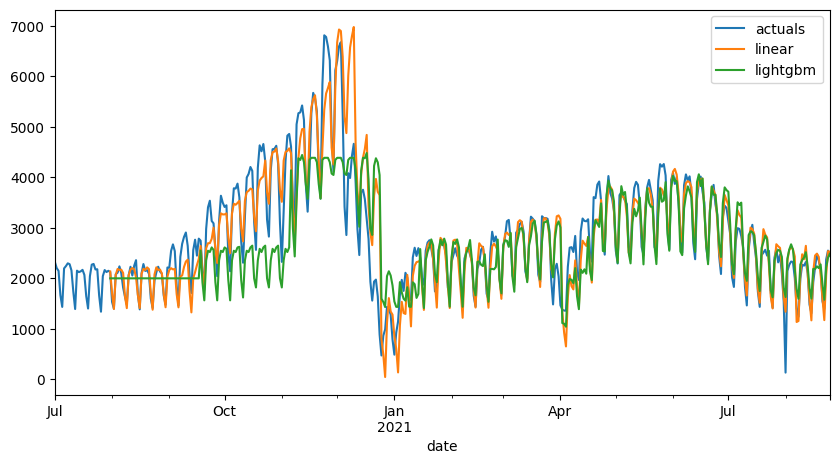

In [18]:
fig, ax = plt.subplots(figsize=(10, 5))
data["users"].plot(ax=ax, label="actuals")
predictions_linear["pred"].plot(ax=ax, label="linear")
predictions_lightgbm["pred"].plot(ax=ax, label="lightgbm")
ax.legend();

Why do you think one model is doing better than the other? What might help one of the models to improve?

The performance of the lightgbm **might** be improved if we were to use:
- More features using feature engineering
- Hyperparameter tuning
- More data (it required more data as it is a more complex model)
- A method to handle the trend in the data

Typically tree based models will do best when working with a large number of multiple time series. Also they struggle when there is a lot of trend in the data. De-trending the data first could help with this.